In [45]:
#import libraries
from keras.models import load_model
import time
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns
#Data Cleaning
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
import string
#Model Evaludation
from sklearn.metrics import accuracy_score
from sklearn import metrics
#Model Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#Stemmer and Lemmatizer intialization
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()*"

In [0]:
#utility function to clean the dataset
def datacleaning(remove_stopwords,useStemming,useLemma,removePuncs,newdata):
  cleanReview=[]
  for x in range(0,len(newdata.values)):
    tmpReview=[]
    for w in nltk.word_tokenize(newdata.values[x]):
        newWord = str(w).lower() #Set newWork to be the updated word
        if remove_stopwords and (w in stopwords_en):#if the word is a stopword & we want to remove stopwords
            continue #skip the word and don’t had it to the normalized review
        if removePuncs and (w in punctuations):#if the word is a punc. & we want to remove punctuations
            continue #skip the word and don’t had it to the normalized review
        if useStemming: #if useStemming is set to True
            #Keep one stemmer commented out
            #newWord = porter.stem(newWord) #User porter stemmer
            newWord = lancaster.stem(newWord) #Use Lancaster stemmer
        if useLemma:
            newWord = wordnet_lemmatizer.lemmatize(newWord)
        tmpReview.append(newWord) #Add normalized word to the tmp review
    cleanReview.append(' '.join(tmpReview))
  return cleanReview

In [0]:
#Read the dataset
url= 'https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv'
dataset = pd.read_csv(url, sep='\t')

In [49]:
dataset.shape

(156060, 4)

In [50]:
#Top 10 Rows of dataset
dataset.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [51]:
dataset['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [0]:
#Count of Each Sentiment
df_plot=dataset['Sentiment'].value_counts()

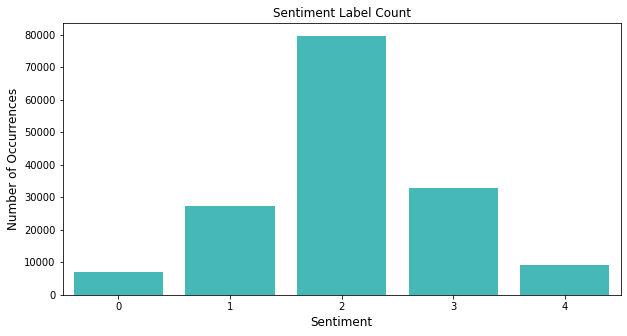

In [53]:
#Plot the sentiment class count
plt.figure(figsize=(10,5))
sns.barplot(df_plot.index, df_plot.values, alpha=0.8,color='c')
plt.title('Sentiment Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()
#plt.savefig('/content/drive/My Drive/NLP_Assignment_2/Imbalance.png', format='png', dpi=1200)

In [0]:
#Split the dataset in Test Train
X_train, X_test, Y_train, Y_test = train_test_split(dataset['Phrase'],dataset['Sentiment'], test_size=0.3, random_state=2003)

In [55]:
print(X_train.shape)
print(X_test.shape)

(109242,)
(46818,)


In [56]:
#Form a dataframe for the training data
temp_clean=pd.concat([X_train,Y_train],axis=1)
temp_clean.head(10)

,Phrase,Sentiment
13718,their ages,2
91191,gorgeous epic,4
97160,fans of the gross-out comedy,2
143983,"The filmmaker ascends , literally , to the Oly...",4
37501,twisting mystery,2
44396,including mine -RRB-,2
40166,more enjoyable than its predecessor,3
30005,film that 's flawed and brilliant in equal mea...,3
67570,bask,2
89575,If ever a concept came handed down from the mo...,4


In [0]:
#Train data cleaning
clean_x_train=datacleaning(True,False,True,True,X_train)

In [0]:
#Concat the clean data to the train dataframe
temp_clean['Cleaned']=clean_x_train

In [59]:
temp_clean.head(10)

,Phrase,Sentiment,Cleaned
13718,their ages,2,age
91191,gorgeous epic,4,gorgeous epic
97160,fans of the gross-out comedy,2,fan gross-out comedy
143983,"The filmmaker ascends , literally , to the Oly...",4,the filmmaker ascends literally olympus art world
37501,twisting mystery,2,twisting mystery
44396,including mine -RRB-,2,including mine -rrb-
40166,more enjoyable than its predecessor,3,enjoyable predecessor
30005,film that 's flawed and brilliant in equal mea...,3,film 's flawed brilliant equal measure
67570,bask,2,bask
89575,If ever a concept came handed down from the mo...,4,if ever concept came handed movie god silver p...


In [0]:
#check for empty entries after removing stop mords
#list(temp_clean['Cleaned']=='').count(True)

In [0]:
#drop empty entries
#nan_value = float("NaN")
#temp_clean.replace("", nan_value, inplace=True)
#temp_clean.dropna(subset = ["Cleaned"], inplace=True)

In [0]:
#drop duplicates
#temp_clean.drop_duplicates(subset=['Cleaned', 'Sentiment'],inplace=True)

In [63]:
temp_clean.shape

(109242, 3)

In [64]:
#Count of sentiment label in training data
temp_clean['Sentiment'].value_counts()

2    55595
3    23055
1    19203
4     6468
0     4921
Name: Sentiment, dtype: int64

In [0]:
#TFIDF vectorization of train data with top 3000 features
#vectorizer = CountVectorizer(stop_words="english",ngram_range=(1, 1))
vectorizer_tfid = TfidfVectorizer(stop_words="english",ngram_range=(1, 2),max_features=3000)
x_train = vectorizer_tfid.fit_transform(temp_clean['Cleaned'])
y_train = temp_clean['Sentiment']


In [66]:
#input vector shape
x_train.shape

(109242, 3000)

In [0]:
#Convert the train data to numpy
x_train_np = x_train.toarray()
y_train_np = np.array(y_train)

In [68]:
#Reshape the train data for Conv1d and y_train categorical
x_train_np=x_train_np.reshape(x_train_np.shape[0],x_train_np.shape[1],1)
print(x_train_np.shape)
y_train_np = to_categorical(y_train_np)
print(y_train_np.shape)

(109242, 3000, 1)
(109242, 5)


In [0]:
#Utility function for recall, precesion and F1 score
#Ref: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0 ,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0 ,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
#import for building the model
from keras.models import Sequential
from keras import layers
from keras.metrics import categorical_accuracy
from keras.layers import Dense, Conv1D, Conv2D ,Flatten, MaxPooling1D, MaxPooling2D,Dropout
from keras.layers import Activation, GlobalMaxPooling1D
from keras.layers import LeakyReLU
from keras import optimizers

In [0]:
#Model Defination
#Ref:
#https://github.com/joseph10081987/Machine-Learning_new/blob/master/Movie%20Review_DL.ipynb
#https://datascience.stackexchange.com/questions/10048/what-is-the-best-keras-model-for-multi-class-classification

cnnmodel = Sequential()
cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu',input_shape=(x_train_np.shape[1],x_train_np.shape[2])))
cnnmodel.add(MaxPooling1D(pool_size=2))
cnnmodel.add(Dropout(rate=0.2))
cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnnmodel.add(MaxPooling1D(pool_size=2))
cnnmodel.add(Dropout(rate=0.2))
cnnmodel.add(Flatten())
cnnmodel.add(layers.Dense(5, activation='softmax'))

In [72]:
#Compile the model
cnnmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
cnnmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 2999, 32)          96        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1499, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1499, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1498, 64)          4160      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 749, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 749, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 47936)            

In [73]:
#Train the model
modelhistory= cnnmodel.fit(x_train_np, y_train_np, epochs=25, verbose=1, validation_split=0.2, batch_size = 64)

Train on 87393 samples, validate on 21849 samples
Epoch 1/25
87393/87393 [==============================] - 14s 162us/step - loss: 1.1368 - acc: 0.5531 - f1_m: 0.4749 - precision_m: 0.6253 - recall_m: 0.3903 - val_loss: 1.0664 - val_acc: 0.5754 - val_f1_m: 0.5346 - val_precision_m: 0.6510 - val_recall_m: 0.4548
Epoch 2/25
87393/87393 [==============================] - 14s 159us/step - loss: 1.0375 - acc: 0.5915 - f1_m: 0.5392 - precision_m: 0.6639 - recall_m: 0.4561 - val_loss: 1.0364 - val_acc: 0.5901 - val_f1_m: 0.5390 - val_precision_m: 0.6697 - val_recall_m: 0.4524
Epoch 3/25
87393/87393 [==============================] - 14s 161us/step - loss: 1.0104 - acc: 0.6025 - f1_m: 0.5556 - precision_m: 0.6705 - recall_m: 0.4759 - val_loss: 1.0295 - val_acc: 0.5955 - val_f1_m: 0.5360 - val_precision_m: 0.6774 - val_recall_m: 0.4450
Epoch 4/25
87393/87393 [==============================] - 14s 159us/step - loss: 0.9995 - acc: 0.6045 - f1_m: 0.5589 - precision_m: 0.6711 - recall_m: 0.4805 - v

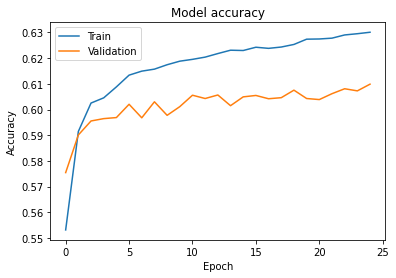

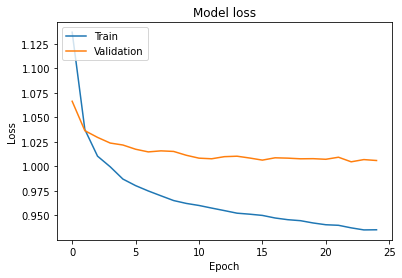

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(modelhistory.history['acc'])
plt.plot(modelhistory.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('/content/drive/My Drive/NLP_Assignment_2/Accuracy.png', format='png', dpi=1200)
plt.show()


# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('/content/drive/My Drive/NLP_Assignment_2/Loss.png', format='png', dpi=1200)
plt.show()


In [75]:
#Save Model
#!apt-get install libhdf5-serial-dev
#import h5py
#cnnmodel.save('/content/drive/My Drive/NLP_Assignment_2/0892691_1dconv_reg.h5')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhdf5-serial-dev is already the newest version (1.10.0-patch1+docs-4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [76]:
#Creat dataframe for testdata
temp_test=pd.concat([X_test,Y_test],axis=1)
temp_test.head(10)

,Phrase,Sentiment
13510,veteran,3
61932,many definitions,2
82549,a worthwhile glimpse,3
137718,past Seagal films,2
121990,banal script,1
3045,a surge through swirling rapids or a leap from...,2
64342,does n't really deliver for country music fans...,1
125461,backed off,1
49978,required reading,2
138979,the protagonists ' bohemian boorishness,1


In [0]:
#Test data cleaning
clean_x_test=datacleaning(True,False,True,True,X_test)

In [0]:
#Concat clean data
temp_test['CleanedTest']=clean_x_test

In [79]:
temp_test.shape

(46818, 3)

In [80]:
temp_test.head(10)

,Phrase,Sentiment,CleanedTest
13510,veteran,3,veteran
61932,many definitions,2,many definition
82549,a worthwhile glimpse,3,worthwhile glimpse
137718,past Seagal films,2,past seagal film
121990,banal script,1,banal script
3045,a surge through swirling rapids or a leap from...,2,surge swirling rapid leap pinnacle pinnacle
64342,does n't really deliver for country music fans...,1,n't really deliver country music fan family au...
125461,backed off,1,backed
49978,required reading,2,required reading
138979,the protagonists ' bohemian boorishness,1,protagonist bohemian boorishness


In [0]:
#vectorise test data
x_test = vectorizer_tfid.transform(temp_test['CleanedTest'])
y_test = temp_test['Sentiment']

In [0]:
# Convert the testing data
x_test_np = x_test.toarray()
y_test_np = np.array(y_test)

In [83]:
#reshape the test data and conver sentiment to categorical
x_test_np=x_test_np.reshape(x_test_np.shape[0],x_test_np.shape[1],1)
print(x_test_np.shape)
y_test_np = to_categorical(y_test_np)
print(y_test_np.shape)

(46818, 3000, 1)
(46818, 5)


In [84]:
#testing results
print(cnnmodel.metrics_names)
cnnmodel.evaluate(x_test_np, y_test_np)

['loss', 'acc', 'f1_m', 'precision_m', 'recall_m']
46818/46818 [==============================] - 4s 92us/step


[1.0043735486123098,
 0.6102140202486224,
 0.5803372312719571,
 0.6663310128247459,
 0.5161262762185485]